https://www/kaggle.com/c/digit-ecognizer

### Задание: выделить признаки для картинок-цифр из датасета MNIST и построить модель классификации для распознования этих цифр, то есть модель на основе изображенной на картинке рукописной цифры предаскаызвает цифру.

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import cv2

from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.reshape(train[:, 1:], (len(train[:, 1:]), 28, 28))
train_img.shape

(42000, 28, 28)

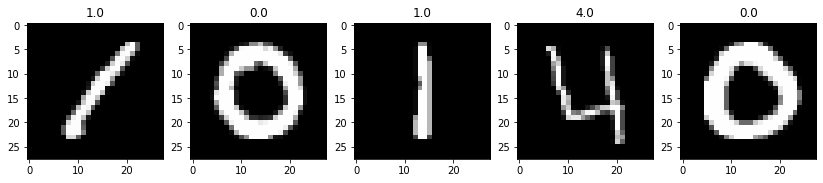

In [3]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [4]:
train_img.shape

(42000, 28, 28)

In [5]:
train_img.reshape(-1, 28 * 28).astype(np.float32)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
train_img.shape

(42000, 28, 28)

Разобьем наш датасет на тренировочную и тестовые выборки, для проверки результатов предсказания модели. При этом есть два варианта признаков: 
    - Ximg_train - это в оригинальном виде картинки 28*28
    - Xtrain - это вытянутые в одну строку признаки картикни

In [7]:
y = train_label
Ximg_train, Ximg_test, y_train, y_test = train_test_split(train_img, y, random_state=42, stratify = train_label)
X_train = Ximg_train.reshape(-1, 28 * 28).astype(np.float32)
X_test = Ximg_test.reshape(-1, 28 * 28).astype(np.float32)

##### Вариант 1: Попробуем "в лоб" скормить модели логистической регрессии картинки, где в качестве признаков используются соотвествующие значения пикселей (цвет) картинок.

In [8]:
lr_asis = LogisticRegression(random_state=0, max_iter=600).fit(X_train, y_train)
y_pred = lr_asis.predict(X_test)

C:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      1033
         1.0       0.94      0.97      0.95      1171
         2.0       0.88      0.87      0.88      1044
         3.0       0.89      0.88      0.88      1088
         4.0       0.91      0.90      0.90      1018
         5.0       0.85      0.82      0.84       949
         6.0       0.93      0.94      0.94      1034
         7.0       0.92      0.93      0.92      1100
         8.0       0.85      0.84      0.84      1016
         9.0       0.86      0.88      0.87      1047

    accuracy                           0.90     10500
   macro avg       0.90      0.90      0.90     10500
weighted avg       0.90      0.90      0.90     10500



Вывод: результат достаточно неплохой f1-score = 0.9. Хуже отлавливаются цифры 2,3,5,8 - порядка 80+%. Успешность предсказания по ним имеет примерно 85%. Попробуем улучшить результаты другими методами

##### Вариант 2: Попробуем применить PCA преобразование для уменьшения количества признаков

In [10]:
pca = PCA()
pca.fit(X_train)

PCA()

In [11]:
print(pca.explained_variance_ratio_[:3])

[0.09743591 0.07151073 0.06176876]


в varience_ratio представлены дисперсии для проекций на опорные вектора в порядке убывания. Каждая дисперсия - это вклад ортогонального вектора в полноту (вариантивность) данных. Как видим из графика накопленной дисперсии при использовании только первых 150 векторов мы получем охват (условно точность или полноту-вариативность) около 95%.

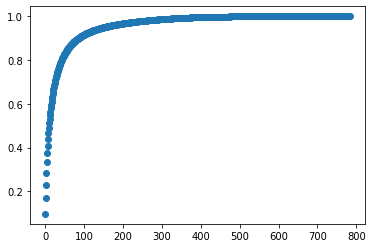

In [12]:
S_cumsum = np.cumsum(pca.explained_variance_ratio_) / np.sum(pca.explained_variance_ratio_)
plt.plot(S_cumsum, 'o')

Зададим точность 0.65 и посмотрим сколько нам требуется для этого опорных векторов. Получается 20, что в 3 раза меньше, чем изначальная длительность вектора признаков для картинки

In [13]:
S_thr = 0.65
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))
n_comp

20

Произведем сжатие путем проектции наших данных н выбранное количество первых по порядку опорных векторов и получи новый датасет в новом векторном пространстве. 

In [14]:
pca = PCA(n_components = n_comp)
pca.fit(X_train)
X_train_red = pca.fit_transform(X_train)
X_test_red = pca.fit_transform(X_test)

In [15]:
X_train_red.shape

(31500, 20)

подставим полученный датасет в модель логистической регрессии и сравним результаты с варинатом 1 (признаки-пиксели картинки)

In [16]:
lr_red = LogisticRegression(random_state=0, max_iter=300).fit(X_train_red, y_train)
y_pred_red = lr_red.predict(X_test_red)

C:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [17]:
print(classification_report(y_test, y_pred_red))

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85      1033
         1.0       0.82      0.69      0.75      1171
         2.0       0.05      0.08      0.06      1044
         3.0       0.10      0.11      0.10      1088
         4.0       0.44      0.40      0.42      1018
         5.0       0.11      0.10      0.10       949
         6.0       0.00      0.00      0.00      1034
         7.0       0.60      0.61      0.61      1100
         8.0       0.31      0.38      0.34      1016
         9.0       0.36      0.37      0.36      1047

    accuracy                           0.36     10500
   macro avg       0.37      0.36      0.36     10500
weighted avg       0.37      0.36      0.37     10500



Вывод: при испоьлзовании максимального полноты данных 99% мы получли наихудший результат. по мере снижения полноты данных до 65% мы получили наилучший результат. предположу, что такое количесво признаков оптимально для исползуемого объема датасета. Тем не менее результаты значительно ухудшились и f1-score=36%

##### Вариант 3: Попробуем выделить признаки на основе гистограммы градиентов. 

Для получения градиентов мы применим операторы (фильтры) Собеля с проекциями на оси x и y, а также посчитаем угол между ними. гридиент - это переход цвета, по есь для x составляющей градиента мы получим горизонтальные линии с наибольшим значением, а для y - вертикальные. Кроме того, гистограммы градиентов не так чувствительны к поворотам изображения на картинке, что присутствует в наших цифрах

In [18]:
ksize = 5
train_sobel_x = np.zeros_like(Ximg_train)
train_sobel_y = np.zeros_like(Ximg_train)
for i in range(len(Ximg_train)):
    train_sobel_x[i] = cv2.Sobel(Ximg_train[i], ddepth=cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    train_sobel_y[i] = cv2.Sobel(Ximg_train[i], ddepth=cv2.CV_64F, dx=0, dy=1, ksize=ksize)
test_sobel_x = np.zeros_like(Ximg_test)
test_sobel_y = np.zeros_like(Ximg_test)
for i in range(len(Ximg_test)):
    test_sobel_x[i] = cv2.Sobel(Ximg_test[i], ddepth=cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    test_sobel_y[i] = cv2.Sobel(Ximg_test[i], ddepth=cv2.CV_64F, dx=0, dy=1, ksize=ksize)

In [19]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

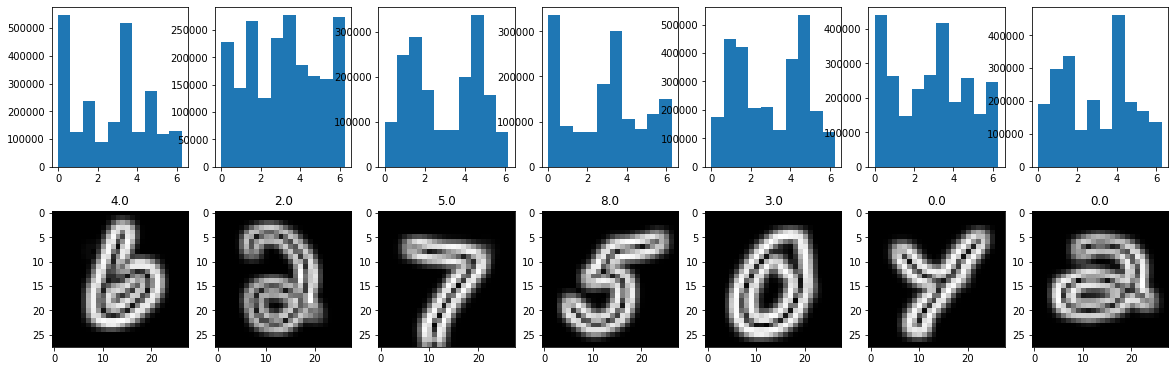

In [20]:
fig = plt.figure(figsize = (20,10))
for i, img in enumerate(train_g[10:17], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % y_train[i - 1])
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i-1].flatten(), bins = 10, weights = train_g[i - 1].flatten())

видим на картинке выше, что по оси Х у нас отложен диапозон углов направления градиентов пикселей (0-2пи), а в качестве значений считаются длины веткоторов во всех пикселях в конкретном диапозоне углов. из игстрограмм вариантов написани различных цифр ниже будет видно, что они имеют схожесть в представлении на гистограмме, то есть модель класификации сможет уловить какие-то паттеррны. (двойные границы, так как два перехода: черный->белыйснаружи цифры и белы->черный внутри цифры)

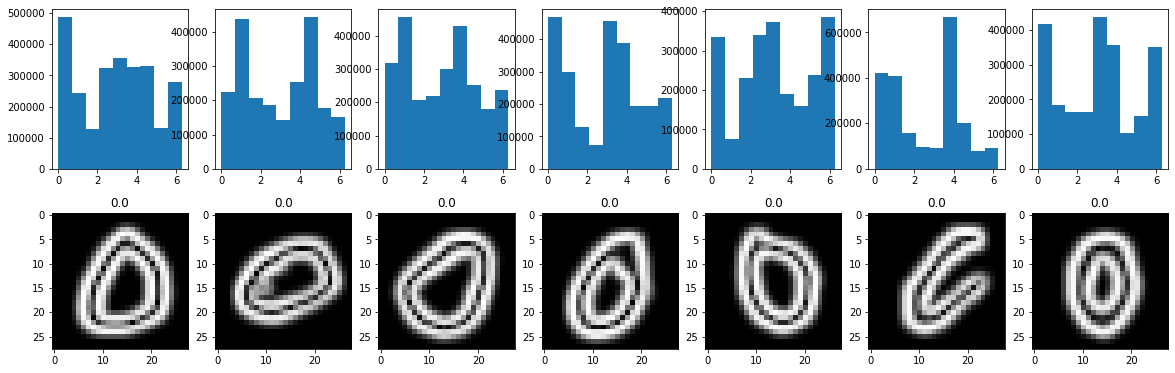

In [21]:
filt = 0
bins = 9
fig = plt.figure(figsize = (20,10))
cnt = 1
for i, img in enumerate(train_g, 1):
    if y_train[i-1] == filt:
        subplot = fig.add_subplot(1, 7, cnt)
        plt.imshow(img, cmap='gray')
        subplot.set_title('%s' % y_train[i - 1])
        subplot = fig.add_subplot(3, 7, cnt)
        plt.hist(train_theta[i-1].flatten(), bins = bins, weights = train_g[i - 1].flatten())
        cnt += 1
    if cnt == 8:
        break

Для нуля мы мидим явно, что 0 и око 4 бина имеют максимумы. иногда в зависмости от наклона появляется и третья составляющая в район 2пи.

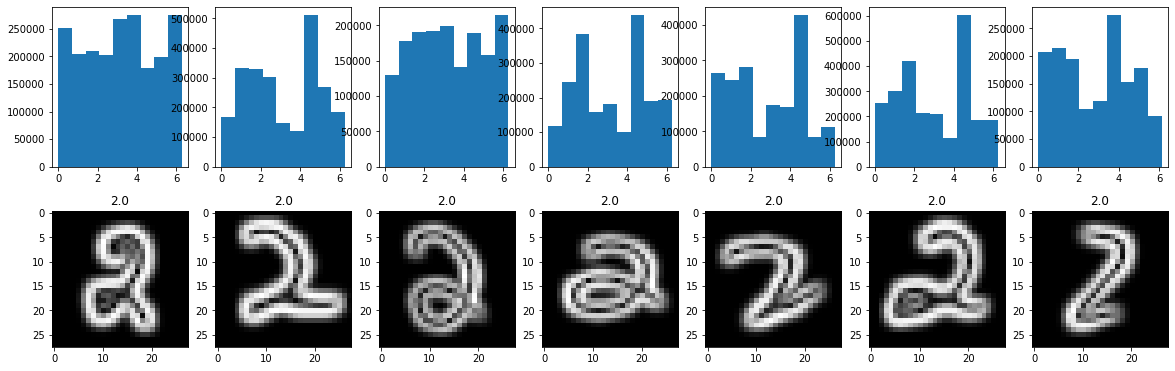

In [22]:
filt = 2
bins = 9
fig = plt.figure(figsize = (20,10))
cnt = 1
for i, img in enumerate(train_g, 1):
    if y_train[i-1] == filt:
        subplot = fig.add_subplot(1, 7, cnt)
        plt.imshow(img, cmap='gray')
        subplot.set_title('%s' % y_train[i - 1])
        subplot = fig.add_subplot(3, 7, cnt)
        plt.hist(train_theta[i-1].flatten(), bins = bins, weights = train_g[i - 1].flatten())
        cnt += 1
    if cnt == 8:
        break

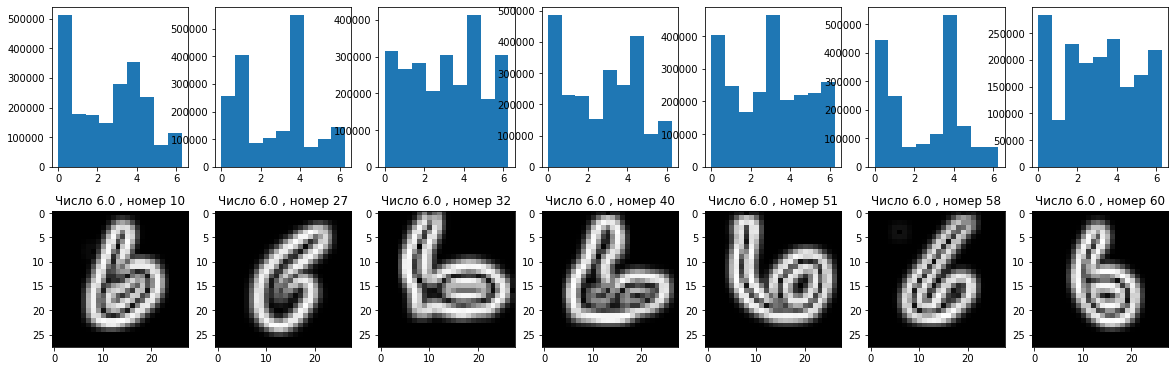

In [23]:
filt = 6
bins = 9
fig = plt.figure(figsize = (20,10))
cnt = 1
for i, img in enumerate(train_g, 1):
    if y_train[i-1] == filt:
        subplot = fig.add_subplot(1, 7, cnt)
        plt.imshow(img, cmap='gray')
        subplot.set_title('Число %s , номер %s'%(y_train[i - 1],i-1))
        subplot = fig.add_subplot(3, 7, cnt)
        plt.hist(train_theta[i-1].flatten(), bins = bins, weights = train_g[i - 1].flatten())
        cnt += 1
    if cnt == 8:
        break

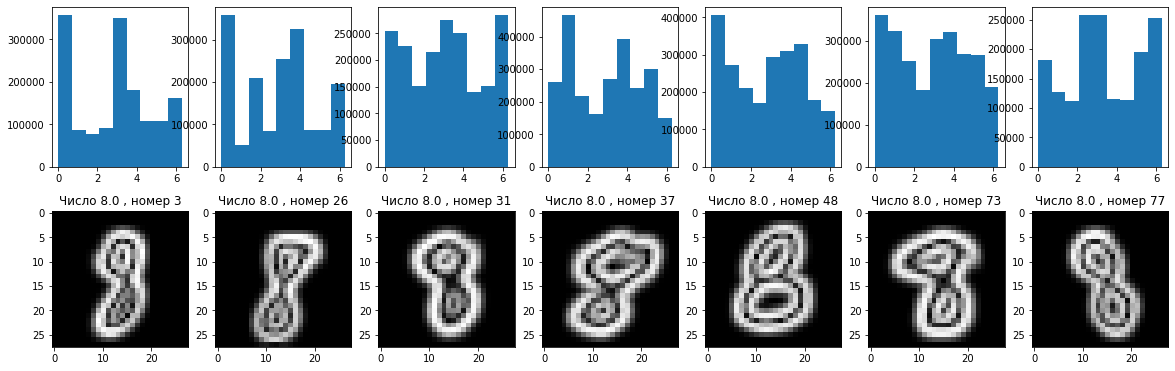

In [24]:
filt = 8
bins = 9
fig = plt.figure(figsize = (20,10))
cnt = 1
for i, img in enumerate(train_g, 1):
    if y_train[i-1] == filt:
        subplot = fig.add_subplot(1, 7, cnt)
        plt.imshow(img, cmap='gray')
        subplot.set_title('Число %s , номер %s'%(y_train[i - 1],i-1))
        subplot = fig.add_subplot(3, 7, cnt)
        plt.hist(train_theta[i-1].flatten(), bins = bins, weights = train_g[i - 1].flatten())
        cnt += 1
    if cnt == 8:
        break

разобьем диапозон углов градиентов 0-2пи на 9 участков (bins), то есть 10 значений. Создадим новый вид датасета, где в качестве признаков будет длина градиента определенного диапозона углов (1/10 от 2пи).

In [25]:
bins = 9
X_train_hog = []
for i, img in enumerate(train_g, 1):
    counts, binEdges = np.histogram(train_theta[i-1].flatten() ,bins=bins, weights = train_g[i-1].flatten())
    X_train_hog.append(counts)
X_train_hog = np.array(X_train_hog)

In [26]:
X_test_hog = []
for i, img in enumerate(test_g, 1):
    counts, binEdges = np.histogram(test_theta[i-1].flatten() ,bins=bins, weights = test_g[i-1].flatten())
    X_test_hog.append(counts)
X_test_hog = np.array(X_test_hog)

так как значения градиентов лежал в районе сотен тысяч, то применим масштабирование и переведем их в мылые числа 0-1. Результаты получим вышем чем без преобразоавания.

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()
Xmm_train_hog = scaler.fit_transform(X_train_hog)
Xmm_test_hog = scaler.transform(X_test_hog)

In [28]:
lr_hog_scaled = LogisticRegression(random_state=0, max_iter=300).fit(Xmm_train_hog, y_train)
ymm_pred_hog_scaled = lr_hog_scaled.predict(Xmm_test_hog)

In [30]:
print(classification_report(y_test, ymm_pred_hog_scaled))

              precision    recall  f1-score   support

         0.0       0.66      0.69      0.67      1033
         1.0       0.84      0.94      0.89      1171
         2.0       0.43      0.32      0.37      1044
         3.0       0.54      0.60      0.57      1088
         4.0       0.55      0.48      0.51      1018
         5.0       0.58      0.66      0.62       949
         6.0       0.43      0.40      0.41      1034
         7.0       0.71      0.74      0.73      1100
         8.0       0.46      0.41      0.43      1016
         9.0       0.47      0.50      0.48      1047

    accuracy                           0.58     10500
   macro avg       0.57      0.57      0.57     10500
weighted avg       0.57      0.58      0.57     10500



Вывод: получили более хорошие результаты чем при преобразовании PCA, но далеки от того, что было при варианте 1 (пиксели как признаки). fq-score = 58%. Если был не использовали масштабирование, то результат был бы 53%. При использовании модели случайного леса удалось добиться результатов точности 68%

In [109]:
#без нормализации
lr_hog = LogisticRegression(random_state=0, max_iter=300).fit(X_train_hog, y_train)
y_pred_hog = lr_hog.predict(X_test_hog)
print(classification_report(y_test, y_pred_hog))

              precision    recall  f1-score   support

         0.0       0.66      0.69      0.67      1033
         1.0       0.84      0.94      0.89      1171
         2.0       0.43      0.32      0.37      1044
         3.0       0.54      0.60      0.57      1088
         4.0       0.55      0.48      0.51      1018
         5.0       0.58      0.66      0.62       949
         6.0       0.43      0.40      0.41      1034
         7.0       0.71      0.74      0.73      1100
         8.0       0.46      0.41      0.43      1016
         9.0       0.47      0.50      0.48      1047

    accuracy                           0.58     10500
   macro avg       0.57      0.57      0.57     10500
weighted avg       0.57      0.58      0.57     10500



In [110]:
#с нормализацией KNN
knn = KNeighborsClassifier()
knn.fit(Xmm_train_hog, y_train)
y_pred_knn = knn.predict(Xmm_test_hog)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.64      0.70      0.67      1033
         1.0       0.96      0.97      0.97      1171
         2.0       0.43      0.43      0.43      1044
         3.0       0.56      0.68      0.61      1088
         4.0       0.59      0.63      0.61      1018
         5.0       0.63      0.58      0.60       949
         6.0       0.47      0.43      0.44      1034
         7.0       0.86      0.73      0.79      1100
         8.0       0.56      0.53      0.54      1016
         9.0       0.63      0.62      0.62      1047

    accuracy                           0.63     10500
   macro avg       0.63      0.63      0.63     10500
weighted avg       0.64      0.63      0.63     10500



In [104]:
#с нормализацией Random Forest
rfs = RandomForestClassifier(n_estimators = 200, random_state=0)
rfs.fit(Xmm_train_hog, y_train)
y_pred_rfs = rfs.predict(Xmm_test_hog)
print(classification_report(y_test, y_pred_rfs))

              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72      1033
         1.0       0.97      0.96      0.97      1171
         2.0       0.51      0.47      0.49      1044
         3.0       0.64      0.71      0.67      1088
         4.0       0.67      0.63      0.65      1018
         5.0       0.64      0.69      0.66       949
         6.0       0.54      0.49      0.51      1034
         7.0       0.81      0.80      0.81      1100
         8.0       0.58      0.60      0.59      1016
         9.0       0.65      0.69      0.67      1047

    accuracy                           0.68     10500
   macro avg       0.67      0.67      0.67     10500
weighted avg       0.68      0.68      0.68     10500



##### Вариант 4: Попробуем выделить признаки на основе гистограммы градиентов но более хитрым методом через дескрипторы, которые учитывают определнные области картинки

hog группироует градиенты таким образом, чотб получать некоторые соединенные градиенты, менее шумные и по разным частям картинки получаются разные градиенты, которые потом объединяются в один дескриптор

In [32]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

In [33]:
descriptor = hog.compute(np.uint8(Ximg_train[0]))

print('Descriptor size: %d' % len(descriptor))

Descriptor size: 144


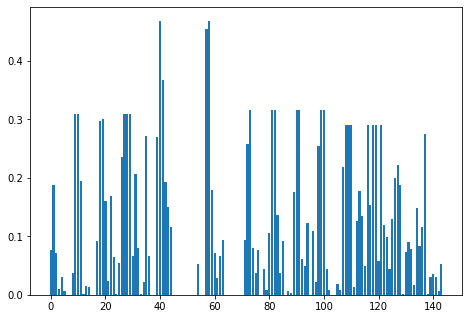

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(descriptor)), descriptor.reshape(-1))
plt.show()

In [35]:
descriptor[:5]

array([0.07648986, 0.18834832, 0.07101544, 0.00930776, 0.03112957],
      dtype=float32)

In [36]:
Xdes_train = np.array([hog.compute(np.uint8(img)) for img in Ximg_train])
Xdes_test = np.array([hog.compute(np.uint8(img)) for img in Ximg_test])

In [37]:
lr_hog_des = LogisticRegression(random_state=0, max_iter=300).fit(Xdes_train, y_train)
y_pred_hog_des = lr_hog_des.predict(Xdes_test)

In [38]:
print(classification_report(y_test, y_pred_hog_des))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1033
         1.0       0.98      0.98      0.98      1171
         2.0       0.96      0.96      0.96      1044
         3.0       0.97      0.97      0.97      1088
         4.0       0.97      0.96      0.97      1018
         5.0       0.97      0.97      0.97       949
         6.0       0.97      0.99      0.98      1034
         7.0       0.96      0.95      0.95      1100
         8.0       0.95      0.94      0.95      1016
         9.0       0.95      0.95      0.95      1047

    accuracy                           0.97     10500
   macro avg       0.97      0.97      0.97     10500
weighted avg       0.97      0.97      0.97     10500



In [120]:
rfs_hog_des = RandomForestClassifier(n_estimators = 200, random_state=0)
rfs_hog_des.fit(Xdes_train, y_train)
y_pred_hog_des_rfs = rfs_hog_des.predict(Xdes_test)
print(classification_report(y_test, y_pred_hog_des_rfs))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1033
         1.0       0.99      0.98      0.98      1171
         2.0       0.95      0.97      0.96      1044
         3.0       0.96      0.97      0.96      1088
         4.0       0.97      0.97      0.97      1018
         5.0       0.98      0.96      0.97       949
         6.0       0.98      0.99      0.99      1034
         7.0       0.95      0.97      0.96      1100
         8.0       0.96      0.94      0.95      1016
         9.0       0.96      0.94      0.95      1047

    accuracy                           0.97     10500
   macro avg       0.97      0.97      0.97     10500
weighted avg       0.97      0.97      0.97     10500



Вывод: мы улучшили результат за счет более умного выделения признаков - дескрипторов и он выше чем при применении варианта 1 (пиксели как признаки). сейчас результат f1-score -97%

# приложение

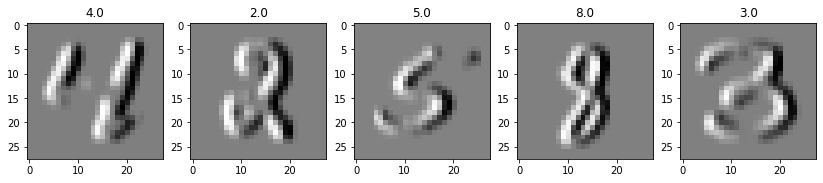

In [133]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_sobel_x[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_train[i - 1]);

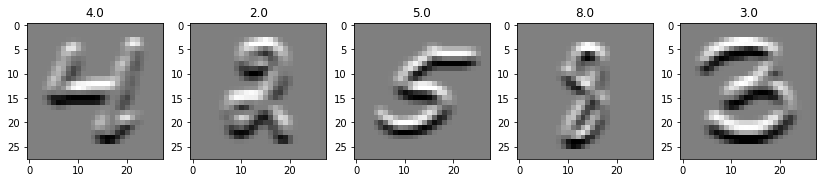

In [135]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_sobel_y[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_train[i - 1]);

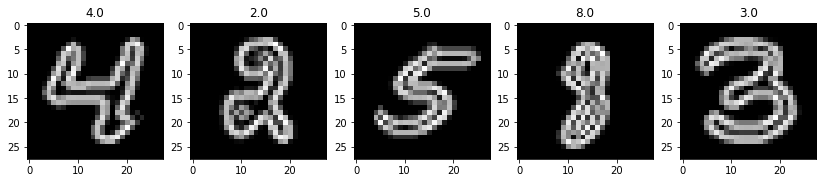

In [137]:
fig = plt.figure(figsize=(20, 10))
for i, (imgx, imgy) in enumerate(list(zip(train_sobel_x, train_sobel_y))[0:5], 1):
    grad = np.sqrt(imgx ** 2 + imgy ** 2)
    #theta = np.arctan2(imgx, imgy)
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(grad, cmap='gray');
    subplot.set_title('%s' % y_train[i - 1]);

### Подгрузим, преобразуем тестовый датасет и сгенерируем файл с ответами для Kaggle

In [40]:
test = np.loadtxt('test_mnist.csv', delimiter=',', skiprows=1)

In [45]:
test_img = np.reshape(test, (len(test), 28, 28))
test_img.shape

(28000, 28, 28)

Подставим в модель тестовые данные с для признаков, формированных HOG Descriptor

In [47]:
Xdes_test_final = np.array([hog.compute(np.uint8(img)) for img in test_img])

In [49]:
Xdes_test_final.shape

(28000, 144)

In [54]:
y_pred_hog_des_test = lr_hog_des.predict(Xdes_test_final)

Подставим в модель тестовые данные, сгенерированные с помощью HOG

In [113]:
Xtest = test_img.reshape(-1, 28 * 28).astype(np.float32)
ksize = 5
bins=9
test_sobel_x_fin = np.zeros_like(test_img)
test_sobel_y_fin = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x_fin[i] = cv2.Sobel(test_img[i], ddepth=cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    test_sobel_y_fin[i] = cv2.Sobel(test_img[i], ddepth=cv2.CV_64F, dx=0, dy=1, ksize=ksize)
test_g_fin, test_theta_fin = cv2.cartToPolar(test_sobel_x_fin, test_sobel_y_fin) 

test_hog = []
for i, img in enumerate(test_g_fin, 1):
    counts, binEdges = np.histogram(test_theta_fin[i-1].flatten() ,bins=bins, weights = test_g_fin[i-1].flatten())
    test_hog.append(counts)
test_hog = np.array(test_hog)
test_mm_hog = scaler.transform(test_hog)
у_pred_test = rfs.predict(test_mm_hog)

In [118]:
#random forest classifier with HOG
with open('submit_rfc_hog.csv','w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(у_pred_test, 1):
        dst.write('%d,%d\n' % (i,p))


In [121]:
#random forest classifier with HOG descriptor
with open('submit_rfc_hogdes.csv','w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_hog_des_test, 1):
        dst.write('%d,%d\n' % (i,p))